# Data Import

In [25]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import timedelta

from datetime import datetime
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes import BetaGeoFitter
from lifetimes.fitters.gamma_gamma_fitter import GammaGammaFitter

from hyperopt import hp, fmin, tpe, rand, SparkTrials, STATUS_OK, space_eval, Trials

In [26]:
FILES_DIR = './files/'
total = pd.read_csv(FILES_DIR + 'total.csv')

In [27]:
raw_data = total.copy()

In [28]:
raw_data.drop('Unnamed: 0', axis=1, inplace=True)

# 전체고객 LTV

In [29]:
suc_data = raw_data[raw_data['event_name'] == 'purchase_success'] # 전체고객

In [30]:
ltv_data = suc_data[['user_no', 'event_timestamp', 'price']]
ltv_data['event_timestamp'] = pd.to_datetime(ltv_data['event_timestamp']).dt.date
ltv_data

,user_no,event_timestamp,price
40,l1wFRhb3av5rTWyYEofrIA==,2021-07-22,128000.0
49,l1wFRhb3av5rTWyYEofrIA==,2021-07-22,128000.0
52,Y5GM63HPuFwrRnvYhDu7sQ==,2021-06-05,29900.0
53,Y5GM63HPuFwrRnvYhDu7sQ==,2021-06-05,29900.0
55,Y5GM63HPuFwrRnvYhDu7sQ==,2021-06-10,38000.0
...,...,...,...
5544515,wyp6zUTd+pvmORMJUL+q5A==,2021-08-04,19000.0
5544516,BccBYWyTrdoNwc3A6leNzA==,2021-08-04,89000.0
5544518,01Lx4dn3rhevMsn3FmXm2g==,2021-08-04,15000.0
5544526,8okJXtYVKYoBoBAG823v2Q==,2021-08-04,25000.0


In [31]:
current_date = ltv_data['event_timestamp'].max()

metrics_df = summary_data_from_transaction_data(ltv_data
                                          , customer_id_col = 'user_no'
                                          , datetime_col = 'event_timestamp'
                                          , monetary_value_col='price'
                                          , observation_period_end=current_date)
metrics_df.head()

,frequency,recency,T,monetary_value
user_no,,,,
+++T9c17sr6wEYOy9UFv3w==,3.0,18.0,50.0,80200.0
+++aQH5NnhiU/9qECKk3uQ==,1.0,11.0,55.0,68000.0
++0bwiYVJ/TAsCpxI4UCuw==,0.0,0.0,8.0,0.0
++1HN9s1imztN8ftPCt3LA==,0.0,0.0,55.0,0.0
++2StXdzG0Bj/Kkb5EFcog==,0.0,0.0,36.0,0.0


In [32]:
l2_reg = 0.01 # lifetime 공식 홈페이지에서 0.1 ~ 0.001사이값을 넣어주는게 효과적이라고 한다
model = BetaGeoFitter(penalizer_coef=l2_reg)
model = GammaGammaFitter(penalizer_coef=l2_reg)

In [33]:
holdout_days = 30 # 총일수 92일
calibration_end_date = current_date - timedelta(days = holdout_days)

metrics_cal_df = calibration_and_holdout_data(ltv_data
                                          ,customer_id_col = 'user_no'
                                          ,datetime_col = 'event_timestamp'
                                          ,calibration_period_end=calibration_end_date # train 데이터 기간
                                          ,observation_period_end=current_date         # 끝 기간
                                          ,monetary_value_col='price')

metrics_cal_df.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
user_no,,,,,,,
+++T9c17sr6wEYOy9UFv3w==,3.0,18.0,20.0,80200.0,0.0,0.0,30.0
+++aQH5NnhiU/9qECKk3uQ==,1.0,11.0,25.0,68000.0,0.0,0.0,30.0
++1HN9s1imztN8ftPCt3LA==,0.0,0.0,25.0,0.0,0.0,0.0,30.0
++2StXdzG0Bj/Kkb5EFcog==,0.0,0.0,6.0,0.0,0.0,0.0,30.0
++2c5Jr8sOEvXXs326kLYQ==,0.0,0.0,16.0,0.0,0.0,0.0,30.0


In [34]:
## frequency가 0인 것은 제외하기
whole_filtered_df = metrics_df[metrics_df.frequency > 0]
filtered_df       = metrics_cal_df[metrics_cal_df.frequency_cal > 0]

In [35]:
# 평가 지표: default는 MSE
def score_model(actuals, predicted, metric='mse'):

    metric = metric.lower()

    # MSE / RMSE
    if metric=='mse' or metric=='rmse':
        val = np.sum(np.square(actuals-predicted))/actuals.shape[0]
    elif metric=='rmse':
        val = np.sqrt(val)
    # MAE
    elif metric=='mae':
        val = np.sum(np.abs(actuals-predicted))/actuals.shape[0]
    else:
        val = None

    return val

# BG/NBD 모형 평가
def evaluate_bgnbd_model(param):

    data   = inputs
    l2_reg = param

    # 모형 적합
    model = BetaGeoFitter(penalizer_coef=l2_reg)
    model.fit(data['frequency_cal'], data['recency_cal'], data['T_cal'])

    # 모형 평가
    frequency_actual = data['frequency_holdout']
    frequency_predicted = model.predict(data['duration_holdout']
                                        , data['frequency_cal']
                                        , data['recency_cal']
                                        , data['T_cal']
                                       )
    mse = score_model(frequency_actual, frequency_predicted, 'mse')

    return {'loss': mse, 'status': STATUS_OK}

# Gamma/Gamma 모델 평가
def evaluate_gg_model(param):

    data   = inputs
    l2_reg = param

    # GammaGamma 모형 적합
    model = GammaGammaFitter(penalizer_coef=l2_reg)
    model.fit(data['frequency_cal'], data['monetary_value_cal'])

    # 모형 평가
    monetary_actual = data['monetary_value_holdout']
    monetary_predicted = model.conditional_expected_average_profit(data['frequency_holdout'], data['monetary_value_holdout'])
    mse = score_model(monetary_actual, monetary_predicted, 'mse')

    # return score and status
    return {'loss': mse, 'status': STATUS_OK}

In [36]:
search_space = hp.uniform('l2', 0.0, 1.0)
algo = tpe.suggest
trials = Trials()
inputs = filtered_df

argmin = fmin(
  fn = evaluate_bgnbd_model, # 목적함수
  space = search_space,      # 파라미터 공간
  algo = algo,               # 최적화 알고리즘: Tree of Parzen Estimators (TPE)
  max_evals=100,             # 반복수
  trials=trials            
  )

l2_bgnbd = space_eval(search_space,argmin)
print(l2_bgnbd)

100%|██████████| 100/100 [00:44<00:00,  2.24trial/s, best loss: 1.8870424064710776]
0.0004752678972260358


In [37]:
search_space = hp.uniform('l2', 0.0, 1.0)
algo = tpe.suggest
trials = Trials()
inputs = filtered_df

# GammaGamma
argmin = fmin(
  fn = evaluate_gg_model,
  space = search_space,
  algo = algo,
  max_evals=100,
  trials=trials
  )

l2_gg = space_eval(search_space,argmin)
print(l2_gg)

100%|██████████| 100/100 [00:22<00:00,  4.49trial/s, best loss: 32514298.177239478]
0.0011283446393213564


In [38]:
lifetimes_model = BetaGeoFitter(penalizer_coef=l2_bgnbd) #l2_bgnbd = hyperopt로 나온 결과
# calibration 데이터의 R,F,T로 모형 적합
lifetimes_model.fit(filtered_df['frequency_cal'], filtered_df['recency_cal'], filtered_df['T_cal']) 

# holdout 데이터로 모델 평가: F의 실제값과 예측값의 MSE
frequency_actual = filtered_df['frequency_holdout']
frequency_predicted = lifetimes_model.predict(filtered_df['duration_holdout']
                                    ,filtered_df['frequency_cal']
                                    , filtered_df['recency_cal']
                                    , filtered_df['T_cal'])
mse = score_model(frequency_actual, frequency_predicted, 'mse')
print('MSE: {0}'.format(mse))

MSE: 1.8870424064710776


In [39]:
lifetimes_model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,6.241713,0.113586,6.019085,6.464341
alpha,55.900406,1.123277,53.698783,58.102028
a,0.552877,0.031784,0.490581,0.615173
b,0.786707,0.048491,0.691665,0.881749


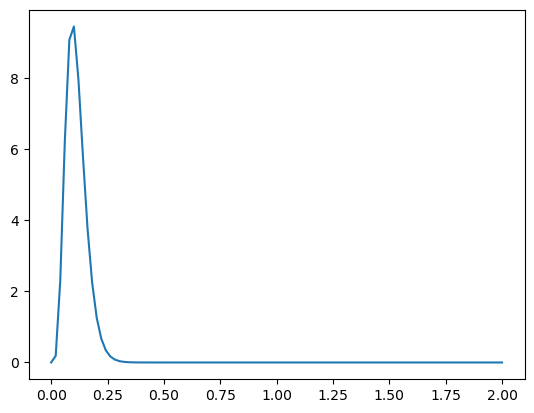

In [40]:
# 고객별 구매율 분포
from scipy.stats import gamma
coefs = lifetimes_model.summary['coef']
x = np.linspace (0, 2, 100) 
y = gamma.pdf(x, a=coefs['r'], scale=1/coefs['alpha']) # BG/NBD에서의 모수 alpha는 scale 모수가 아닌 rate 모수이므로 역수!

plt.plot(x, y)

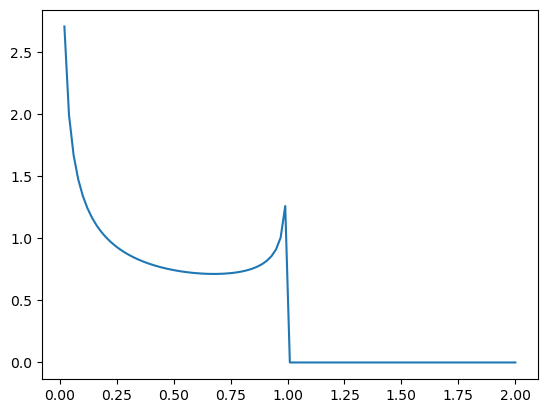

In [41]:
# 고객별 구매하지 않을 분포
from scipy.stats import gamma
from scipy.stats import beta
coefs = lifetimes_model.summary['coef']
x = np.linspace (0, 2, 100) 
y = beta.pdf(x, a=coefs['a'], b=coefs['b']) 

plt.plot(x, y)

In [42]:
spend_model = GammaGammaFitter(penalizer_coef=l2_gg)
spend_model.fit(filtered_df['frequency_cal'], filtered_df['monetary_value_cal'])

# conditional_expected_average_profit: 고객별 평균 구매 금액 예측
monetary_actual = filtered_df['monetary_value_holdout']
monetary_predicted = spend_model.conditional_expected_average_profit(filtered_df['frequency_holdout']
                                                                    ,filtered_df['monetary_value_holdout'])

mse = score_model(monetary_actual, monetary_predicted, 'mse')

print('MSE: {0}'.format(mse))

MSE: 32514298.177239478


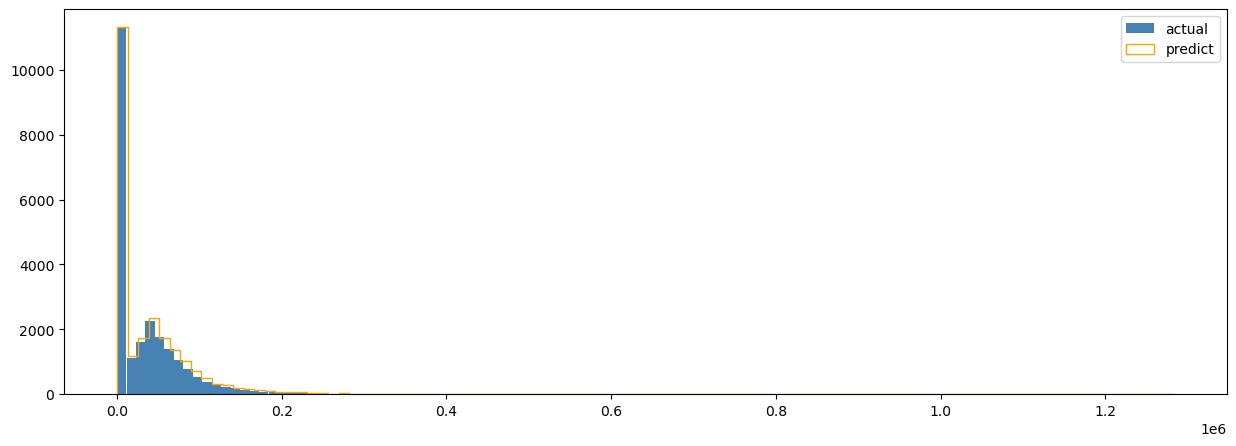

In [43]:
bins = 100
plt.figure(figsize=(15, 5))

plt.hist(monetary_actual, bins, label='actual', histtype='bar', color='STEELBLUE', rwidth=0.99)
plt.hist(monetary_predicted, bins, label='predict', histtype='step', color='ORANGE',  rwidth=0.99)
plt.legend(loc='upper right')

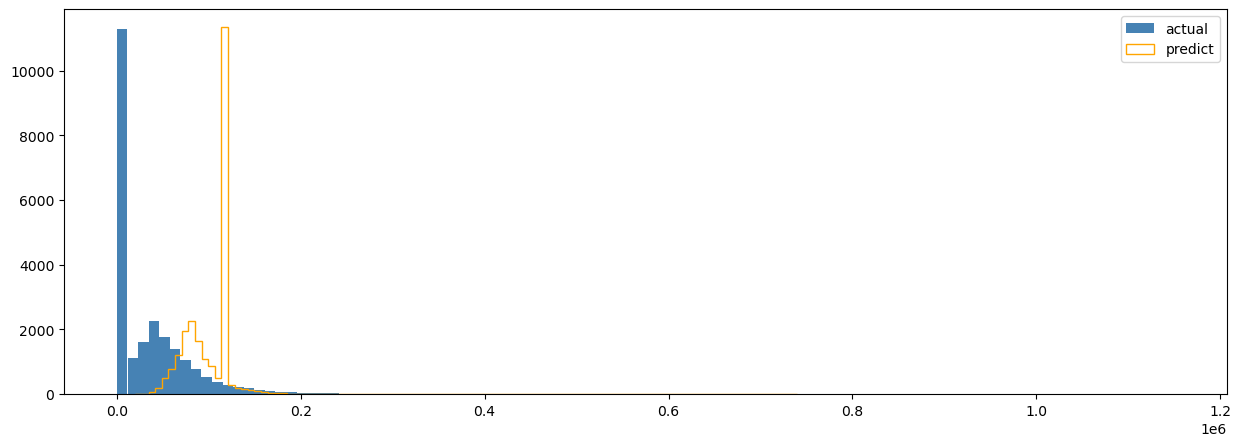

In [44]:
# penalizer_coef 없이 했을 때의 결과
spend_model = GammaGammaFitter(penalizer_coef=0)
spend_model.fit(filtered_df['frequency_cal'], filtered_df['monetary_value_cal'])

# 평가
monetary_actual = filtered_df['monetary_value_holdout']
monetary_predicted = spend_model.conditional_expected_average_profit(filtered_df['frequency_holdout']
                                                                    ,filtered_df['monetary_value_holdout'])

mse = score_model(monetary_actual, monetary_predicted, 'mse')

bins = 100
plt.figure(figsize=(15, 5))

plt.hist(monetary_actual, bins, label='actual', histtype='bar', color='STEELBLUE', rwidth=0.99)
plt.hist( monetary_predicted, bins, label='predict', histtype='step', color='ORANGE',  rwidth=0.99)
plt.legend(loc='upper right')

In [45]:
final_df = whole_filtered_df.copy()
final_df['ltv'] = spend_model.customer_lifetime_value(lifetimes_model,
                                                     final_df['frequency'],
                                                     final_df['recency'],
                                                     final_df['T'],
                                                     final_df['monetary_value'],
                                                     time=12,
                                                     discount_rate=0.01
                                                     )

In [46]:
t=92 
final_df['predicted_purchases'] = lifetimes_model.conditional_expected_number_of_purchases_up_to_time(t
                                                                                      , final_df['frequency']
                                                                                     , final_df['recency']
                                                                                     , final_df['T'])

In [47]:
final_df['predicted_monetary_value'] = spend_model.conditional_expected_average_profit(final_df['frequency']
                                                                    ,final_df['monetary_value'])

In [48]:
final_df.sort_values(by='ltv', ascending=False)

,frequency,recency,T,monetary_value,ltv,predicted_purchases,predicted_monetary_value
user_no,,,,,,,
b2xZVfUtjyGsZckO7j6zkg==,43.0,53.0,54.0,6.754674e+05,5.937365e+07,33.102230,6.595262e+05
pywOPeCTmJKudBVHC1/5iw==,5.0,50.0,57.0,2.187580e+06,2.453259e+07,5.505526,1.769608e+06
b/lqkmii6O9hL/CH0kWgLA==,51.0,62.0,62.0,1.968627e+05,1.968946e+07,36.692530,1.949466e+05
ZQbCiAWfK++gLSwDa2OqYw==,17.0,58.0,61.0,5.232024e+05,1.848900e+07,13.919441,4.951157e+05
DYNvLcoA3LAg4XxUzFizRQ==,20.0,56.0,58.0,4.357950e+05,1.836946e+07,16.400164,4.168708e+05
...,...,...,...,...,...,...,...
90CDewFV9JUhjckMNXjLZg==,1.0,1.0,60.0,1.150000e+04,4.723930e+03,0.029491,7.081695e+04
FTJcVH7vxyjf4J1+PK8x0g==,1.0,1.0,61.0,1.380000e+04,4.482302e+03,0.027559,7.183235e+04
CuGOw0h+hvGSzsIkz6sYyA==,1.0,1.0,62.0,1.980000e+04,4.349855e+03,0.025768,7.448122e+04


### 앱 지속시간이 길다면 LTV가 높은가?

In [50]:
final_df[final_df.index == 'UxbJuWLml+M4McU8Q5hNqA==']

,frequency,recency,T,monetary_value,ltv,predicted_purchases,predicted_monetary_value
user_no,,,,,,,
UxbJuWLml+M4McU8Q5hNqA==,4.0,49.0,51.0,487450.0,5.292131e+06,5.38734,398606.027076
